# BP神经网络预测

In [1]:
# 导入包
import torch
from torch import nn
import numpy as np
import torch.nn.functional as Fun
import scipy.io as scio
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

# 读取数据

In [2]:
file_name = "data.mat"
data = scio.loadmat(file_name)
x = data.get("PPP")
x = x.T
y = data.get("TTT")
y = y[0].reshape(len(y[0]),1)

In [3]:
print("x.shape :", x.shape, " y.shape: ", y.shape)

x.shape : (205, 4)  y.shape:  (205, 1)


In [4]:
print(x[0:5])

[[ 9.53333333e+01  7.73333333e+01  3.67333333e+01 -7.13518730e-01]
 [ 1.04333333e+02  5.80000000e+01  3.32000000e+01 -6.43337135e-01]
 [ 9.50000000e+01  7.30000000e+01  3.55000000e+01  9.59860109e-02]
 [ 9.40000000e+01  7.10000000e+01  3.51000000e+01  3.01645487e-01]
 [ 1.03000000e+02  6.73333333e+01  3.64666667e+01 -4.38108606e-02]]


In [5]:
print(y[0:5])

[[4.6]
 [6.6]
 [9.1]
 [5.1]
 [5.3]]


In [6]:
x_mean = np.mean(x,axis=0)
print(x_mean)
x_std = np.std(x,axis=0)
x = (x-x_mean) / x_std
print(x_std)
x = torch.tensor(x, dtype = torch.float32)
y = torch.tensor(y, dtype = torch.float32)

[99.58211382 70.27642276 35.3295935  -0.13151976]
[8.14764866 9.24648983 1.04861871 0.43334363]


In [7]:
print(x[0:5])

tensor([[-0.5215,  0.7632,  1.3387, -1.3430],
        [ 0.5831, -1.3277, -2.0309, -1.1811],
        [-0.5624,  0.2946,  0.1625,  0.5250],
        [-0.6851,  0.0783, -0.2189,  0.9996],
        [ 0.4195, -0.3183,  1.0844,  0.2024]])


In [8]:
print(y[0:5])

tensor([[4.6000],
        [6.6000],
        [9.1000],
        [5.1000],
        [5.3000]])


In [9]:
def split_train_test(X, y, test_ratio):
    shuffled_indices = np.random.permutation(len(y))
    test_set_size = int(len(y) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return X[train_indices,:], y[train_indices], X[test_indices,:], y[test_indices]

In [10]:
train_x, train_y, test_x, test_y = split_train_test(x, y, 0.4)

In [11]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

(torch.Size([123, 4]),
 torch.Size([123, 1]),
 torch.Size([82, 4]),
 torch.Size([82, 1]))

## 将numy转换为tensor

In [12]:
dataset = torch.utils.data.TensorDataset(train_x, train_y)
train_iter = torch.utils.data.DataLoader(dataset, 5 ,shuffle=True)

## 定义BP神经网络

In [13]:
class Net(torch.nn.Module):
    def __init__(self, n_features, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_features, n_hidden)
        self.out = torch.nn.Linear(n_hidden, n_output)

    def forward(self, X_data):
        x = self.hidden(X_data)
        x_relu = Fun.tanh(x)
        predict_y = self.out(x_relu)
        return predict_y

In [14]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss(clipped_preds.log(),labels.log()).mean())
    return rmse.item()

In [15]:
net = Net(4, 9, 1)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
loss = torch.nn.MSELoss()

In [16]:
train_ls, test_ls = [], []
for i in range(1000):
    for x, y in train_iter:
        out = net(x)
        l = loss(out, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    train_ls.append(l)
    if test_ls is not None:
        test_ls.append(loss(net(test_x), test_y))

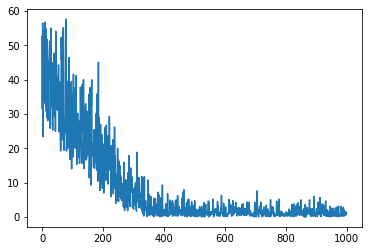

In [17]:
plt.plot(train_ls)
plt.show()

In [18]:
predict_y = net(test_x).detach_().numpy()
predict_y[0:5]

array([[7.3157   ],
       [5.389013 ],
       [5.1016526],
       [7.016416 ],
       [6.851646 ]], dtype=float32)

In [19]:
for parameters in net.parameters():
    print(parameters)

Parameter containing:
tensor([[-0.0937, -0.0473,  0.2556, -0.0544],
        [-0.0942, -0.0899,  0.2349, -0.0779],
        [-0.1109, -0.0637,  0.3233, -0.0990],
        [ 0.0558,  0.2078, -0.6698, -0.0172],
        [-0.0753, -0.0307,  0.4009,  0.0672],
        [-0.2038,  0.0691, -0.0508, -0.1282],
        [-0.1499, -0.0193, -0.4493, -0.0943],
        [-0.0662, -0.1195,  0.1419, -0.0169],
        [ 0.2365,  0.0148,  0.4925,  0.3181]], requires_grad=True)
Parameter containing:
tensor([-1.2410, -0.7839, -1.1849,  1.1129, -1.2483, -0.6176, -0.7892, -0.6930,
         0.7802], requires_grad=True)
Parameter containing:
tensor([[-1.0550, -0.5821, -0.9781,  1.2010, -1.1437, -0.6723, -1.0174, -0.6198,
          0.5236]], requires_grad=True)
Parameter containing:
tensor([0.8095], requires_grad=True)


In [20]:
# clarke网格误差分析
def clarke(y,y_predicted):
    """
    clarke网格分析

    total, percentage = clarke(y, yp)
    
    INPUTS:
    y       Reference values(血糖浓度参考值)
    yp      Predicted/estimated values(血糖预测值)
    
    OUTPUTS:

    """
    # 设置坐标轴范围和坐标轴名称
    plt.xlim(0, 400*0.0556)
    plt.ylim(0, 400*0.0556)
    plt.xlabel('Reference values of Blood Glucose(mmol/L)')
    plt.ylabel('Predicted values of Blood Glucose(mmol/L)')
    # 获取数据长度
    n = len(y)
    # 散点图绘制数据
    plt.scatter(y, y_predicted, s=15)
    # 绘制网线
    # 上半区网线
    plt.plot([0,400*0.0556],[0,400*0.0556],linestyle=':',c='k') 
    plt.plot([0,175*0.0556/3],[70*0.0556,70*0.0556],c='k',linewidth=1)
    plt.plot([175*0.0556/3,400*0.0556/1.2],[70*0.0556,400*0.0556],c='k',linewidth=1)
    plt.plot([70*0.0556,70*0.0556],[84*0.0556,400*0.0556],c='k', linewidth=1)
    plt.plot([0,70*0.0556],[180*0.0556,180*0.0556],c='k',linewidth=1)
    plt.plot([70*0.0556,290*0.0556],[180*0.0556,400*0.0556],c='k', linewidth=1)
    # 下半区网线绘制
    plt.plot([70*0.0556,70*0.0556],[0,56*0.0556],c='k',linewidth=1)
    plt.plot([70*0.0556,400*0.0556],[56*0.0556,320*0.0556],c='k',linewidth=1)
    plt.plot([180*0.0556,180*0.0556],[0,70*0.0556],c='k',linewidth=1)
    plt.plot([180*0.0556,400*0.0556],[70*0.0556,70*0.0556],c='k',linewidth=1)
    plt.plot([240*0.0556,240*0.0556],[70*0.0556,180*0.0556],c='k',linewidth=1)
    plt.plot([240*0.0556,400*0.0556],[180*0.0556,180*0.0556],c='k',linewidth=1)
    plt.plot([130*0.0556,180*0.0556],[0,70*0.0556],c='k',linewidth=1)
    
    # 绘制区域标签A,B,C,D,E
    plt.text(30*0.0556,20*0.0556,'A',fontsize=9)
    plt.text(30*0.0556,150*0.0556,'D',fontsize=9)
    plt.text(30*0.0556,380*0.0556,'E',fontsize=9)
    plt.text(150*0.0556,380*0.0556,'C',fontsize=9)
    plt.text(160*0.0556,20*0.0556,'C',fontsize=9)
    plt.text(380*0.0556,20*0.0556,'E',fontsize=9)
    plt.text(380*0.0556,120*0.0556,'D',fontsize=9)
    plt.text(380*0.0556,260*0.0556,'B',fontsize=9)
    plt.text(280*0.0556,380*0.0556,'B',fontsize=9)

    # 计算数据
    total = np.zeros(5)
    # A区域
    for i in range(0,n):
        if (y[i] <= 70*0.0556 and y_predicted[i] <= 70*0.0556) or (y_predicted[i] <= 1.2*y[i] and y_predicted[i] >= 0.8*y[i]): 
            total[0] = total[0] + 1
        else:
            # E区域
            if(y[i] >= 180*0.0556 and y_predicted[i] <= 70*0.0556) or (y[i] <= 70*0.0556 and y_predicted[i] >= 180*0.0556):
                total[4] = total[4] + 1
            else:
                # 区域C
                if (y[i] >= 70*0.0556 and y[i] <= 290*0.0556) and (y_predicted[i] >= y[i] + 110*0.0556) or (y[i] >= 130*0.0556 and y[i] <= 180*0.0556) and (y_predicted[i] <= (7/5)*y[i] - 182*0.0556):
                    total[2] = total[2] + 1
                else:
                    # 区域D
                    if (y[i] >= 240*0.0556) and (y_predicted[i] >= 70*0.0556) and (y_predicted[i] <= 180*0.0556) or (y[i] <= 175*0.0556/3 and y_predicted[i] <= 180*0.0556) and (y_predicted[i] >= 70*0.0556) or (y[i] >= 175*0.0556/3 and y[i] <= 70*0.0556) and (y_predicted[i] >= (6/5)*y[i]):
                        total[3] = total[3] + 1
                    else:
                        # 区域B
                        total[1] = total[1] + 1

    percentage = (total/n)*100
    plt.show()
    return total, percentage

In [21]:
test_y = (test_y).numpy()

In [22]:
test_y.size

82

In [23]:
predict_y.size

82

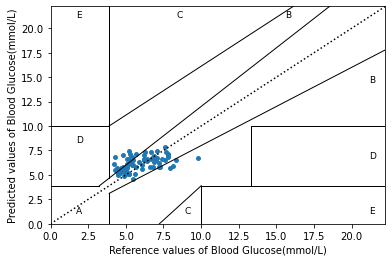

In [24]:
total, percentage = clarke(test_y, predict_y)

In [25]:
print(test_y[0:5])

[[7.7]
 [4.9]
 [4.5]
 [7.8]
 [6.8]]


In [26]:
print(predict_y[0:5])

[[7.3157   ]
 [5.389013 ]
 [5.1016526]
 [7.016416 ]
 [6.851646 ]]


In [27]:
total

array([63., 19.,  0.,  0.,  0.])

In [28]:
percentage

array([76.82926829, 23.17073171,  0.        ,  0.        ,  0.        ])

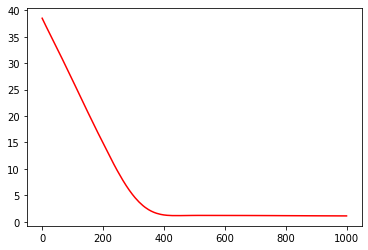

In [29]:
plt.plot(test_ls, c='r')
plt.show()

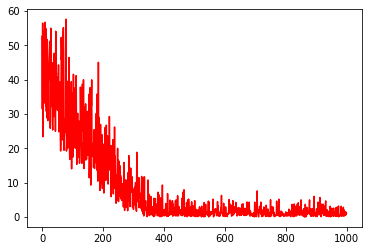

In [30]:
plt.plot(train_ls, c='r')
plt.show()

In [31]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'PPP', 'TTT', 'ppp1', 'ttt1', 'ppp2', 'ttt2', 'ppp3', 'ttt3', 'ppp4', 'ttt4', 'ppp5', 'ttt5', 'ppp6', 'ttt6', 'ppp7', 'ttt7', 'ppp8', 'ttt8', 'ppp9', 'ttt9', 'ppp10', 'ttt10', 'pop1', 'tot1', 'pop2', 'tot2', 'pop3', 'tot3', 'pop4', 'tot4', 'pop5', 'tot5', 'pop6', 'tot6', 'pop7', 'tot7', 'pop8', 'tot8', 'pop9', 'tot9', 'pop10', 'tot10'])

In [81]:
diff = test_y - predict_y
diff.shape

(82, 1)

In [83]:
a=[]
for i in range(82):
    a.append(i)

plt.bar(a, diff)
plt.show()

TypeError: only size-1 arrays can be converted to Python scalars